### Importing Libraries

In [1]:
import os
from IPython import display
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Reshape, Flatten, Conv2D, Conv2DTranspose, LeakyReLU, BatchNormalization
from keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import load_img, img_to_array

### Data Processing

In [2]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [3]:
data_dir = "Stage_4"

img_width, img_height = 224, 224 # 224 for DCGAN
batch_size = 32

# Load all images from the folder
def load_images_from_folder(folder_path):
    images = []
    for filename in os.listdir(folder_path):
        img = load_img(os.path.join(folder_path, filename), target_size=(img_width, img_height))
        img_array = img_to_array(img)
        img_tensor = tf.convert_to_tensor(img_array)
        images.append(img_tensor)
    return np.array(images)

# Load images from the folder
train = load_images_from_folder(data_dir)

In [4]:
train

array([[[[ 81.,  81.,  81.],
         [ 83.,  83.,  83.],
         [ 86.,  86.,  86.],
         ...,
         [ 90.,  90.,  90.],
         [ 87.,  87.,  87.],
         [ 88.,  88.,  88.]],

        [[ 81.,  81.,  81.],
         [ 83.,  83.,  83.],
         [ 87.,  87.,  87.],
         ...,
         [ 90.,  90.,  90.],
         [ 89.,  89.,  89.],
         [ 89.,  89.,  89.]],

        [[ 80.,  80.,  80.],
         [ 84.,  84.,  84.],
         [ 87.,  87.,  87.],
         ...,
         [ 91.,  91.,  91.],
         [ 90.,  90.,  90.],
         [ 88.,  88.,  88.]],

        ...,

        [[139., 139., 139.],
         [140., 140., 140.],
         [146., 146., 146.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[135., 135., 135.],
         [134., 134., 134.],
         [145., 145., 145.],
         ...,
         [  0.,   0.,   0.],
         [  0.,   0.,   0.],
         [  0.,   0.,   0.]],

        [[137., 137., 137.],
       

In [5]:
train = (train - 127.5) / 127.5  # Normalize the images to [-1, 1]

In [6]:
train

array([[[[-0.3647059 , -0.3647059 , -0.3647059 ],
         [-0.34901962, -0.34901962, -0.34901962],
         [-0.3254902 , -0.3254902 , -0.3254902 ],
         ...,
         [-0.29411766, -0.29411766, -0.29411766],
         [-0.31764707, -0.31764707, -0.31764707],
         [-0.30980393, -0.30980393, -0.30980393]],

        [[-0.3647059 , -0.3647059 , -0.3647059 ],
         [-0.34901962, -0.34901962, -0.34901962],
         [-0.31764707, -0.31764707, -0.31764707],
         ...,
         [-0.29411766, -0.29411766, -0.29411766],
         [-0.3019608 , -0.3019608 , -0.3019608 ],
         [-0.3019608 , -0.3019608 , -0.3019608 ]],

        [[-0.37254903, -0.37254903, -0.37254903],
         [-0.34117648, -0.34117648, -0.34117648],
         [-0.31764707, -0.31764707, -0.31764707],
         ...,
         [-0.28627452, -0.28627452, -0.28627452],
         [-0.29411766, -0.29411766, -0.29411766],
         [-0.30980393, -0.30980393, -0.30980393]],

        ...,

        [[ 0.09019608,  0.09019608,  0

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


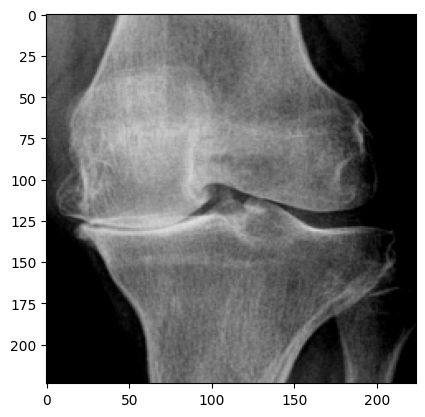

In [7]:
plt.imshow(train[2])

In [8]:
train.shape

(536, 224, 224, 3)

### DCGAN - Tensorflow

In [9]:
# # Generator
# def build_generator(latent_dim):
#     input_noise = Input(shape=(latent_dim,))
#     x = Dense(7*7*256)(input_noise)
#     x = Reshape((7, 7, 256))(x)
#     x = Conv2DTranspose(128, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 28x28
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2DTranspose(64, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 112x112
#     x = BatchNormalization()(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2DTranspose(1, kernel_size=5, strides=2, padding='same', activation='tanh')(x)  # Adjust the strides to upscale to 224x224
#     generator = Model(input_noise, x)
#     return generator

# # Discriminator
# def build_discriminator(input_shape):
#     input_image = Input(shape=input_shape)
#     x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
#     x = LeakyReLU(alpha=0.01)(x)
#     x = Flatten()(x)
#     x = Dense(1, activation='sigmoid')(x)
#     discriminator = Model(input_image, x)
#     return discriminator

# # Combined model
# def build_dcgan(generator, discriminator):
#     discriminator.trainable = False
#     input_noise = Input(shape=(latent_dim,))
#     generated_image = generator(input_noise)
#     validity = discriminator(generated_image)
#     dcgan = Model(input_noise, validity)
#     return dcgan

# # Define the input shape and latent dimension
# input_shape = (224, 224, 1)
# latent_dim = 100

# # Build the generator, discriminator, and DCGAN models
# generator = build_generator(latent_dim)
# discriminator = build_discriminator(input_shape)
# dcgan = build_dcgan(generator, discriminator)

# # Compile the discriminator and DCGAN models
# discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
# dcgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))

In [10]:
from keras.layers import Input, Dense, Reshape, Conv2D, Conv2DTranspose, Flatten, BatchNormalization, LeakyReLU
from keras.models import Model
from keras.optimizers import Adam

# Generator
def build_generator(latent_dim):
    input_noise = Input(shape=(latent_dim,))
    x = Dense(7*7*256)(input_noise)
    x = Reshape((7, 7, 256))(x)
    x = Conv2DTranspose(128, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 28x28
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(64, kernel_size=5, strides=4, padding='same')(x)  # Adjust the strides to upscale to 112x112
    x = BatchNormalization()(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2DTranspose(3, kernel_size=5, strides=2, padding='same', activation='tanh')(x)  # Adjust the strides to upscale to 224x224 and output 3 channels
    generator = Model(input_noise, x)
    return generator

# Discriminator
def build_discriminator(input_shape):
    input_image = Input(shape=input_shape)
    x = Conv2D(64, kernel_size=5, strides=2, padding='same')(input_image)
    x = LeakyReLU(alpha=0.01)(x)
    x = Conv2D(128, kernel_size=5, strides=2, padding='same')(x)
    x = LeakyReLU(alpha=0.01)(x)
    x = Flatten()(x)
    x = Dense(1, activation='sigmoid')(x)
    discriminator = Model(input_image, x)
    return discriminator

# Combined model
def build_dcgan(generator, discriminator):
    discriminator.trainable = False
    input_noise = Input(shape=(latent_dim,))
    generated_image = generator(input_noise)
    validity = discriminator(generated_image)
    dcgan = Model(input_noise, validity)
    return dcgan

# Define the input shape and latent dimension
input_shape = (224, 224, 3)  # Changed to 3 channels
latent_dim = 100

# Build the generator, discriminator, and DCGAN models
generator = build_generator(latent_dim)
discriminator = build_discriminator(input_shape)
dcgan = build_dcgan(generator, discriminator)

# Compile the discriminator and DCGAN models
discriminator.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))
dcgan.compile(loss='binary_crossentropy', optimizer=Adam(learning_rate=0.0002, beta_1=0.5))


In [11]:
def generate_and_save_images(model, epoch, test_input):
  # Notice `training` is set to False.
  # This is so all layers run in inference mode (batchnorm).
  predictions = model(test_input, training=False)

  fig = plt.figure(figsize=(224, 224))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0] * 127.5 + 127.5, cmap='gray')
      plt.axis('off')

  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [16]:
epochs = 50
batch_size = 64

seed = tf.random.normal([16, 100])

# Train the DCGAN model
for epoch in range(epochs):
    for batch in range(train.shape[0] // batch_size):
        # Train the discriminator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        fake_images = generator.predict(noise)
        real_images = train[np.random.randint(0, train.shape[0], batch_size)]
        
        discriminator_loss_real = discriminator.train_on_batch(real_images, np.ones(batch_size))
        discriminator_loss_fake = discriminator.train_on_batch(fake_images, np.zeros(batch_size))
        discriminator_loss = 0.5 * np.add(discriminator_loss_real, discriminator_loss_fake)
        
        # Train the generator
        noise = np.random.normal(0, 1, (batch_size, latent_dim))
        generator_loss = dcgan.train_on_batch(noise, np.ones(batch_size))
    
    # Print the losses
    print(f"Epoch {epoch+1}/{epochs} - Discriminator Loss: {discriminator_loss} - Generator Loss: {generator_loss}")

2/2 [==============================] - 0s 202ms/step
Epoch 1/50 - Discriminator Loss: 1.4941549897193909 - Generator Loss: 0.0015208791010081768
2/2 [==============================] - 0s 199ms/step
Epoch 2/50 - Discriminator Loss: 1.5615603923797607 - Generator Loss: 0.0014268035301938653
2/2 [==============================] - 0s 203ms/step
Epoch 3/50 - Discriminator Loss: 1.6146489679813385 - Generator Loss: 0.001383577473461628
2/2 [==============================] - 0s 206ms/step
Epoch 4/50 - Discriminator Loss: 1.6894338726997375 - Generator Loss: 0.0013293165247887373
2/2 [==============================] - 0s 198ms/step
Epoch 5/50 - Discriminator Loss: 1.741690218448639 - Generator Loss: 0.0013100445503368974
2/2 [==============================] - 0s 214ms/step
Epoch 6/50 - Discriminator Loss: 1.8307473361492157 - Generator Loss: 0.0012697991915047169
2/2 [==============================] - 0s 195ms/step
Epoch 7/50 - Discriminator Loss: 1.8960366249084473 - Generator Loss: 0.0012056

In [18]:
generate_and_save_images(generator, epochs, seed)

1/1 [==============================] - 0s 174ms/step


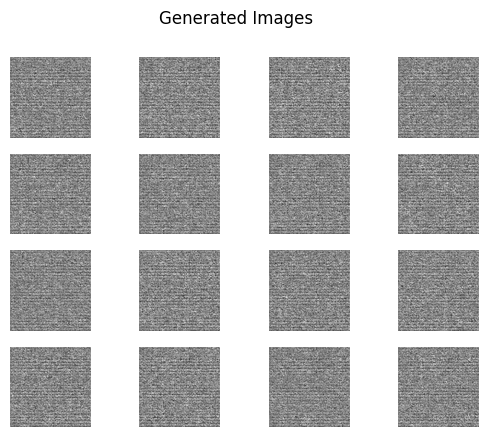

In [17]:
import numpy as np
import matplotlib.pyplot as plt

# Generate random noise
num_samples =  16  # Number of images to generate
noise = np.random.normal(0, 1, (num_samples, latent_dim))  # latent_dim should match the dimensionality of your generator's input

# Generate images using the generator
generated_images = generator.predict(noise)

# Visualize the generated images
fig, axs = plt.subplots(4, 4)
fig.suptitle('Generated Images')
count = 0
for i in range(4):
    for j in range(4):
        axs[i, j].imshow(generated_images[count, :, :, 0], cmap='gray')  # Assuming grayscale images
        axs[i, j].axis('off')
        count += 1
plt.show()


In [9]:
# generator.save("Saved Models/Generator")
# discriminator.save("Saved Models/Discriminator")
# dcgan.save("Saved Models/DCGAN")

### DCGAN - PyTorch

In [14]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np

In [27]:
# Define the Generator network
# class Generator(nn.Module):
#     def _init_(self, nz, ngf, nc):
#         super(Generator, self)._init_()
#         self.main = nn.Sequential(
#             nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
#             nn.BatchNorm2d(ngf*8),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf*4),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf*2),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ngf),
#             nn.ReLU(True),
#             nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
#             nn.Tanh()
#         )

#     def forward(self, input):
#         return self.main(input)
class Generator(nn.Module):
    def __init__(self, nz, ngf, nc):  # Use __init__ instead of _init_
        super(Generator, self).__init__()  # Correct super call
        self.main = nn.Sequential(
            nn.ConvTranspose2d(nz, ngf*8, 4, 1, 0, bias=False),
            nn.BatchNorm2d(ngf*8),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*8, ngf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*4),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*4, ngf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf*2),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf*2, ngf, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ngf),
            nn.ReLU(True),
            nn.ConvTranspose2d(ngf, nc, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, input):
        return self.main(input)

# Define the Discriminator network
# class Discriminator(nn.Module):
#     def _init_(self, nc, ndf):
#         super(Discriminator, self)._init_()
#         self.main = nn.Sequential(
#             nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf*2),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf*4),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
#             nn.BatchNorm2d(ndf*8),
#             nn.LeakyReLU(0.2, inplace=True),
#             nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
#             nn.Sigmoid()
#         )

#     def forward(self, input):
#         return self.main(input)
class Discriminator(nn.Module):
    def __init__(self, nc, ndf):  # Use __init__ instead of _init_
        super(Discriminator, self).__init__()  # Correct super call
        self.main = nn.Sequential(
            nn.Conv2d(nc, ndf, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf, ndf*2, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*2),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*2, ndf*4, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*4),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*4, ndf*8, 4, 2, 1, bias=False),
            nn.BatchNorm2d(ndf*8),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(ndf*8, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, input):
        return self.main(input)

def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        nn.init.normal_(m.weight.data, 0.0, 0.02)
    elif classname.find('BatchNorm') != -1:
        nn.init.normal_(m.weight.data, 1.0, 0.02)
        nn.init.constant_(m.bias.data, 0)


# Set random seed for reproducibility
torch.manual_seed(42)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Hyperparameters
nz = 100 # size of the latent z vector
ngf = 64 # size of feature maps in generator
ndf = 64 # size of feature maps in discriminator
nc = 1 # number of channels in the training images

# Create the generator
netG = Generator(nz, ngf, nc).to(device)

# Create the discriminator
netD = Discriminator(nc, ndf).to(device)

# Initialize weights
netG.apply(weights_init)
netD.apply(weights_init)

# Loss function
criterion = nn.BCELoss()

# Optimizers
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Training loop
dataset = datasets.ImageFolder(root="../Dataset/train", transform=transforms.Compose([
                        transforms.Resize(224),
                        transforms.Grayscale(num_output_channels=1),  # Convert RGB to grayscale
                        transforms.ToTensor(),
                    ]))
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
# dataloader = train

num_epochs = 100
print("Shape of real_cpu:", real_cpu.shape)
# Loop through dataset
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader, 0):
        # Update Discriminator
        netD.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), 1, device=device)
        output = netD(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        noise = torch.randn(b_size, nz, 1, 1, device=device)
        fake = netG(noise)
        label.fill_(0)
        output = netD(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        errD = errD_real + errD_fake
        optimizerD.step()

        # Update Generator
        netG.zero_grad()
        label.fill_(1)
        output = netD(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        optimizerG.step()

        # Output training stats
        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f'
                  % (epoch, num_epochs, i, len(dataloader),
                     errD.item(), errG.item()))

# Generate some fake images
noise = torch.randn(batch_size, nz, 1, 1, device=device)
fake = netG(noise)

Shape of real_cpu: torch.Size([32, 3, 224, 224])


ValueError: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([3872])) is deprecated. Please ensure they have the same size.